![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [360]:
import warnings
warnings.filterwarnings('ignore')

In [361]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz,DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import VotingClassifier, BaggingClassifier
import math

In [362]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [363]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Algunos de los datos son:

##### Season 1:winter, 2:spring, 3:summer, 4:fall

##### temp Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

##### humidity Normalized humidity. The values are divided to 100 (max)

##### holiday weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule


In [364]:
bikes.groupby('season').max()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
season,,,,,,,,,,,
1,1,1,4,29.52,32.575,100,51.9987,367,681,801,23
2,1,1,3,38.54,43.940,100,47.9988,361,782,873,23
3,1,1,3,41.00,45.455,100,56.9969,350,886,977,23
4,1,1,3,30.34,34.090,100,43.0006,362,857,948,23


In [365]:
bikes.groupby('season').min()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
season,,,,,,,,,,,
1,0,0,1,0.82,0.760,0,0.0,0,0,1,0
2,0,0,1,9.84,11.365,16,0.0,0,0,1,0
3,0,0,1,15.58,12.120,17,0.0,0,0,1,0
4,0,0,1,5.74,7.575,16,0.0,0,1,1,0


In [366]:
bikes.groupby('season').quantile([0.25, 0.5, 0.75])

holiday  workingday  weather   temp   atemp  humidity  windspeed  \
season                                                                          
1      0.25      0.0         0.0      1.0   9.02  10.605      41.0     7.0015   
       0.50      0.0         1.0      1.0  12.30  14.395      53.0    12.9980   
       0.75      0.0         1.0      2.0  16.40  20.455      70.0    19.9995   
2      0.25      0.0         0.0      1.0  18.86  22.725      45.0     7.0015   
       0.50      0.0         1.0      1.0  22.96  26.515      61.0    12.9980   
       0.75      0.0         1.0      2.0  26.24  31.060      78.0    19.0012   
3      0.25      0.0         0.0      1.0  26.24  30.305      51.0     7.0015   
       0.50      0.0         1.0      1.0  28.70  33.335      66.0    11.0014   
       0.75      0.0         1.0      2.0  31.16  35.605      78.0    15.0013   
4      0.25      0.0         0.0      1.0  13.12  15.910      52.0     7.0015   
       0.50      0.0         1.0      1.0  16.40  20.455      66.0    11.0014   
       0.75      0.0         1.0      2.0  20.50  24.240      81.0    16.9979   

             casual  registered  total   hour  
season                                         
1      0.25     1.0       22.00   24.0   6.00  
       0.50     5.0       69.00   78.0  12.00  
       0.75    15.0      141.00  164.0  18.00  
2      0.25     8.0       39.00   49.0   6.00  
       0.50    29.0      133.00  172.0  12.00  
       0.75    63.0      243.00  321.0  18.00  
3      0.25    10.0       53.00   68.0   6.00  
       0.50    36.0      151.00  195.0  12.00  
       0.75    74.0      252.00  347.0  18.00  
4      0.25     4.0       46.00   51.0   6.00  
       0.50    14.0      139.00  161.0  12.00  
       0.75    33.0      238.75  294.0  17.75

Usando los codigos anteriores se puede ver los valores maximos, minimos y cuantiles de las otras variables agrupadas por estaciones, algo que es facil de interpretar del agrupamiento por estacion es la temperatura minima maxima, promedio y humedad. Por ejemplo la temperatura minima en invierno fue de 0 grados y la maxima 29.52. 



In [367]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [368]:
bikes.groupby('hour').max()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
hour,,,,,,,,,,,
0,4,1,1,3,33.62,39.395,100,32.9975,68,234,283
1,4,1,1,3,33.62,39.395,100,51.9987,49,139,168
2,4,1,1,3,33.62,38.635,100,46.0022,33,103,119
3,4,1,1,3,32.80,38.635,100,46.0022,22,54,66
4,4,1,1,3,31.98,37.880,100,47.9988,12,22,28
5,4,1,1,3,31.98,37.120,100,36.9974,16,54,57
6,4,1,1,3,31.98,38.635,100,35.0008,19,203,213
7,4,1,1,3,32.80,40.150,100,35.0008,40,572,596
8,4,1,1,3,34.44,41.665,100,39.0007,68,806,839


In [369]:
bikes.groupby('hour').min()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
hour,,,,,,,,,,,
0,1,0,0,1,3.28,3.030,0,0.0,0,0,2
1,1,0,0,1,1.64,1.515,0,0.0,0,0,1
2,1,0,0,1,0.82,0.760,0,0.0,0,0,1
3,1,0,0,1,0.82,0.760,14,0.0,0,0,1
4,1,0,0,1,0.82,2.275,15,0.0,0,0,1
5,1,0,0,1,0.82,2.275,0,0.0,0,1,1
6,1,0,0,1,0.82,2.275,0,0.0,0,0,1
7,1,0,0,1,0.82,2.275,0,0.0,0,1,1
8,1,0,0,1,0.82,3.030,0,0.0,0,7,8


In [370]:
bikes.groupby('hour').quantile([0.25, 0.5, 0.75])

season  holiday  workingday  weather   temp     atemp  humidity  \
hour                                                                         
0    0.25    2.00      0.0         0.0      1.0  12.71  15.91000      56.0   
     0.50    3.00      0.0         1.0      1.0  18.86  22.72500      69.0   
     0.75    3.50      0.0         1.0      2.0  25.42  29.16750      82.0   
1    0.25    2.00      0.0         0.0      1.0  12.30  15.15000      59.0   
     0.50    2.50      0.0         1.0      1.0  18.86  22.72500      70.0   
...           ...      ...         ...      ...    ...       ...       ...   
22   0.50    2.50      0.0         1.0      1.0  20.50  24.24000      65.0   
     0.75    3.25      0.0         1.0      2.0  26.24  30.30500      78.0   
23   0.25    1.75      0.0         0.0      1.0  13.12  16.47625      53.0   
     0.50    2.50      0.0         1.0      1.0  19.68  23.10500      67.0   
     0.75    3.25      0.0         1.0      2.0  25.42  29.54500      81.0   

           windspeed  casual  registered   total  
hour                                              
0    0.25     6.0032     3.0       20.00   24.00  
     0.50     8.9981     7.0       33.00   41.00  
     0.75    15.0013    14.0       62.00   74.50  
1    0.25     6.0032     1.0        8.00   11.00  
     0.50     8.9981     4.0       15.00   19.00  
...              ...     ...         ...     ...  
22   0.50    11.0014    17.0      107.00  129.00  
     0.75    16.9979    32.0      143.25  175.00  
23   0.25     6.0032     5.0       43.00   52.75  
     0.50    11.0014    11.0       68.00   80.00  
     0.75    15.0013    22.0       98.00  123.00  

[72 rows x 11 columns]

Usando los codigos anteriores se puede ver los valores maximos, minimos y cuantiles de las otras variables agrupadas por las horas en el dia. De la misma manera que vimos las estaciones pero esta vez por hora del dia, para todo el año, por ejemplo la  temperatura a las 12 de la media noche (hora 0) minima fue de 3.28 grados y maxima fue de 33.62 grados.

Se puede ver entonces inicialmente que con los datos que se tienen se puede conocer datos para le renta de bicicletas que tienen que ver con datos meteorologicos por hora en el año y por estacion en el año. Cosas que pueden ser muy utiles para entender cuando se usa menos la renta de bicicletas dadas variables meteorologicas

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

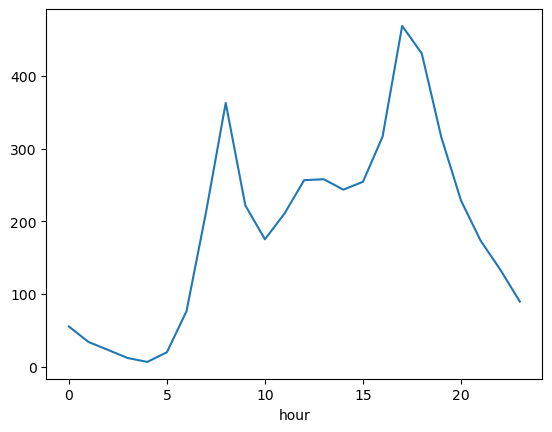

In [371]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"

rentapromediotot=bikes.groupby('hour').total.mean()

rentapromediotot.plot()

<Axes: xlabel='hour'>

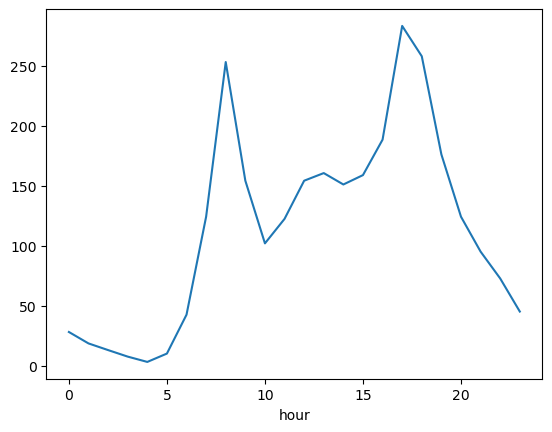

In [372]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
invierno = bikes[bikes['season'] == 1]
inviernoporhora=invierno.groupby('hour').total.mean()
inviernoporhora.plot()

<Axes: xlabel='hour'>

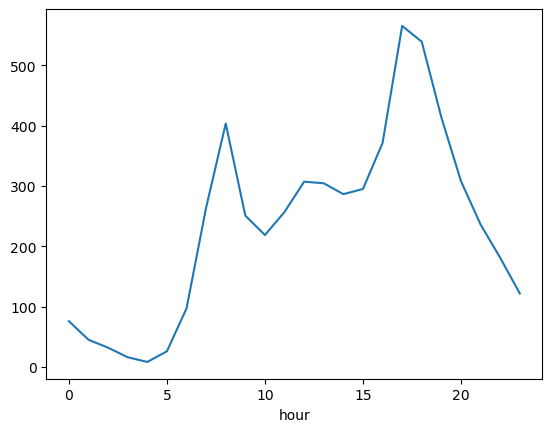

In [373]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
verano = bikes[bikes['season'] == 3]
veranoporhora=verano.groupby('hour').total.mean()
veranoporhora.plot()

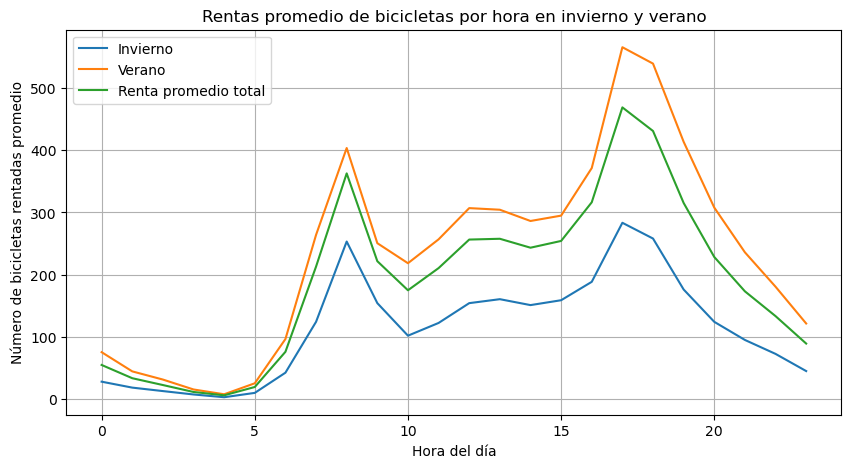

In [374]:
plt.figure(figsize=(10, 5))
plt.plot(inviernoporhora, label='Invierno')
plt.plot(veranoporhora,label= 'Verano')
plt.plot(rentapromediotot,label='Renta promedio total')
plt.xlabel('Hora del día')
plt.ylabel('Número de bicicletas rentadas promedio')
plt.title('Rentas promedio de bicicletas por hora en invierno y verano')
plt.legend()
plt.grid(True)
plt.show()

Como se puede ver en verano es cuando mas rentas promedio se tienen mientras que en invierno es cuando menos se tienen. Sin embargo es interesante notar que durante el año el promedio de bicicletas rentadas por hora sigue una misma distribucion. Es decir que la estacion del año solamente afecta la cantidad de bicicletas rentadas pero sigue una estacionalidad diaria promedio

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [375]:
# Celda 3
X=bikes[['season','hour']]
y=bikes['total']


lr=LinearRegression()

lr.fit(X,y)

print(f"Intercepto: {lr.intercept_}")
print(f"Coeficientes de 'season' y 'hour': {lr.coef_}")

Intercepto: 2.5848513346807067
Coeficientes de 'season' y 'hour': [26.95130851 10.52129824]


#### Intercepto:
Como se puede ver entonces el intercepto es 2.58 quiere decir que cuando ambas variables sean iguales a 0 el numero total de bicicletas alquiladas es 2.58

#### Season
Mientras que dado que 'season' es una variable categórica que toma valores de 1 a 4 (por ejemplo, primavera, verano, otoño, invierno), esto significa que, en promedio, se esperaría un aumento de aproximadamente 26.95 bicicletas alquiladas por cada cambio de una temporada a otra, manteniendo constante la hora.

#### Hour

Para 'hour' se puede decir que  por cada hora adicional que pasa en el dia se esperaría un aumento de aproximadamente 10.52 bicicletas alquiladas

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [376]:
#NUEVAS FUNCIONES
def calculate_mse(X_col, y, split):
    left_indices = X_col < split
    right_indices = ~left_indices
    
    left_y = y[left_indices]
    right_y = y[right_indices]
    
    if len(left_y) == 0 or len(right_y) == 0:
        return float('inf')
    
    left_mean = np.mean(left_y)
    right_mean = np.mean(right_y)
    
    # MSE calculation
    mse_left = np.mean((left_y - left_mean) ** 2)
    mse_right = np.mean((right_y - right_mean) ** 2)
    
    mse = mse_left + mse_right 
    mse /= len(y)
    
    return mse
    
def best_split_mse(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, float('inf')]  # j, split, mse
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            mse = calculate_mse(X.iloc[:, j], y, split)
                        
            if mse < best_split[2]:
                best_split = [j, split, mse]
    
    return best_split

In [377]:
j, split, gain = best_split_mse(X, y, 10)

print(f'La mejor variable es {j} con un punto de corte de {split} y una ganancia de {gain}')

int(np.mean(y))

La mejor variable es 1 con un punto de corte de 6.0 y una ganancia de 2.954064423847527


191

In [378]:
def count_leaf_nodes(tree):
    if 'sl' not in tree and 'sr' not in tree:
        return 1
    else:
        left_count = count_leaf_nodes(tree['sl']) if 'sl' in tree else 0
        right_count = count_leaf_nodes(tree['sr']) if 'sr' in tree else 0
        return left_count + right_count


## Tree grow con MSE

Debido a que los datos son continuos, se debe usar MSE en lugar de gini index

In [379]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol corregida
def tree_grow_mse(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_samples_leaf=6,min_nodes_leaf=6 ):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split_mse(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = np.mean(y)
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada 
    if  gain == float('inf') or gain < min_gain or X.shape[0] <= min_samples_leaf:
        return tree
    
    if max_depth is not None and level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow_mse(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples_leaf=min_samples_leaf)
    tree['sr'] = tree_grow_mse(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples_leaf=min_samples_leaf)
    
    # Verificar el número de nodos finales solo cuando se hayan creado completamente las ramas del árbol
    if level == 0:
        if count_leaf_nodes(tree) < min_nodes_leaf:
            print("Advertencia: El árbol no cumple con el número mínimo de nodos finales.")
         
    
    return tree

In [380]:
tree_mse=tree_grow_mse(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10)
tree_mse

{'y_pred': 191.57413191254824,
 'level': 0,
 'split': [1, 6.0],
 'n_samples': 10886,
 'gain': 2.954064423847527,
 'sl': {'y_pred': 25.177719821162444,
  'level': 1,
  'split': [1, 5.0],
  'n_samples': 2684,
  'gain': 0.4695357505986357,
  'sl': {'y_pred': 26.273297491039425,
   'level': 2,
   'split': [1, 4.0],
   'n_samples': 2232,
   'gain': 0.5644825996300002,
   'sl': {'y_pred': 31.178770949720672,
    'level': 3,
    'split': [1, 3.0],
    'n_samples': 1790,
    'gain': 0.8875826556759271,
    'sl': {'y_pred': 37.375829034635224,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 1357,
     'gain': 1.5332691464392365,
     'sl': {'y_pred': 20.21021021021021,
      'level': 5,
      'split': [1, 2.0],
      'n_samples': 333,
      'gain': 2.4172127849516514,
      'sl': {'y_pred': 23.52654867256637,
       'level': 6,
       'split': [1, 1.0],
       'n_samples': 226,
       'gain': 4.353508947624119,
       'sl': {'y_pred': 28.292035398230087,
        'level': 7,
        '

In [381]:
leaf_count = count_leaf_nodes(tree_mse)
if leaf_count >= 6:
    print("Se cumple la condición de tener al menos 6 nodos finales.")
else:
    print("No se cumple la condición de tener al menos 6 nodos finales.")

Se cumple la condición de tener al menos 6 nodos finales.


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [382]:
#Usando Xtrain y ytrain vs Xtest y Ytest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Calibrar el parámetro max_depth
max_depth_values = range(1, 25)

for max_depth in max_depth_values:
    # Crear el regresor de árbol de decisión
    regressor = DecisionTreeRegressor(max_depth=max_depth)
    
    # Entrenar el regresor
    regressor.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = regressor.predict(X_test)
    
    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MSE with max_depth={max_depth}: {math.sqrt(mse)}")

MSE with max_depth=1: 153.40372424783766
MSE with max_depth=2: 143.02500624709225
MSE with max_depth=3: 132.85210235904196
MSE with max_depth=4: 126.11238477618178
MSE with max_depth=5: 120.97218897981723
MSE with max_depth=6: 115.42752834617531
MSE with max_depth=7: 114.54461181499951
MSE with max_depth=8: 114.09207120931892
MSE with max_depth=9: 114.03764622096037
MSE with max_depth=10: 114.06395896378268
MSE with max_depth=11: 114.06395896378268
MSE with max_depth=12: 114.06395896378268
MSE with max_depth=13: 114.06395896378268
MSE with max_depth=14: 114.06395896378268
MSE with max_depth=15: 114.06395896378268
MSE with max_depth=16: 114.06395896378268
MSE with max_depth=17: 114.06395896378268
MSE with max_depth=18: 114.06395896378268
MSE with max_depth=19: 114.06395896378268
MSE with max_depth=20: 114.06395896378268
MSE with max_depth=21: 114.06395896378268
MSE with max_depth=22: 114.06395896378268
MSE with max_depth=23: 114.06395896378268
MSE with max_depth=24: 114.06395896378268


El menor RMSE es max_depth 7 o mayor solo viendolo a ojo, pasando de:


max_depth=5: 120.97218897981723

*max_depth=6: 115.4275283461753*

max_depth=7: 114.54461181499951

A continuacion se usa cross validation score:

In [383]:
# Usando Cross Val Score que ya separa los datos en Xtrain y Ytrain por si solo

max_depth_range = range(1, 20)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rmse_values = []
max_depth_values = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for max_depth in max_depth_range:
    tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=1)

    cv_scores = cross_val_score(tree_model, X, y, cv=10, scoring='neg_root_mean_squared_error')

    rmse_scores = -cv_scores

    average_mse = rmse_scores.mean()

    max_depth_values.append(max_depth)
    rmse_values.append(average_mse)

best_idx = rmse_values.index(min(rmse_values))

# Imprimir el max_depth y el MSE correspondiente al mínimo MSE
print("Best max_depth:", max_depth_values[best_idx])
print("Lowest RMSE:", rmse_values[best_idx])

Best max_depth: 6
Lowest RMSE: 121.94259382561488


In [384]:
for index in range(len(max_depth_values)):
    print(max_depth_values[index], rmse_values[index])


1 150.58047729549764
2 151.26076616823033
3 142.81500728739763
4 133.98468138783147
5 130.40018956802126
6 121.94259382561488
7 125.97083102000511
8 127.99666727710868
9 128.01573093830402
10 128.118351121229
11 128.11794701248675
12 128.11794701248675
13 128.11794701248675
14 128.11794701248675
15 128.11794701248675
16 128.11794701248675
17 128.11794701248675
18 128.11794701248675
19 128.11794701248675


El menor RMSE usando cross validation es max_depth 6, como el cambio entre 6 y 7 en la primera vista, no es mucho y con cross validation se vio que 6 es mejor, este es el que se utilizara


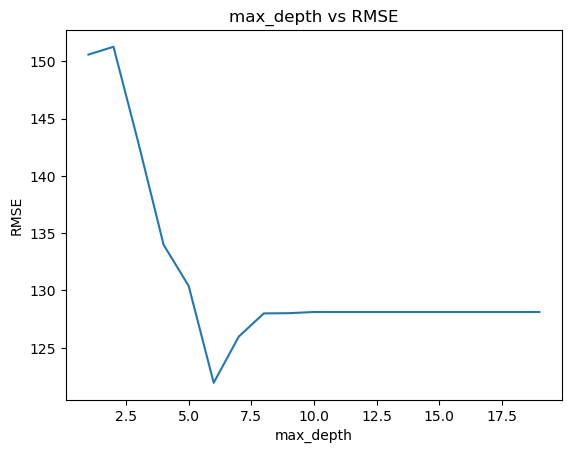

In [385]:
#Graficar
plt.plot(max_depth_values, rmse_values)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('max_depth vs RMSE')

plt.show()

Al parecer se llega al menor max_depth en 6 y despues vuelve a empeorar

In [386]:
# max_depth=6 fue el mejor, se ajusta un árbol usando este valor 
tree_model_depth_6 = DecisionTreeRegressor(max_depth=6, random_state=1)
tree_model_depth_6.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=1)

### Comparacion modelos

In [387]:
#Regresion lineal datos train
lr_5=LinearRegression()

lr_5.fit(X_train,y_train)

LinearRegression()

In [388]:
# Predicciones de regresión lineal
y_pred_lr = lr_5.predict(X_test)

# Predicciones de árbol de decisión
y_pred_tree = tree_model_depth_6.predict(X_test)

# Calcular métricas para regresión lineal
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Calcular métricas para árbol de decisión
rmse_tree = root_mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Imprimir métricas
print("Métricas para regresión lineal:")
print(f"RMSE: {rmse_lr}")
print(f"MAE: {mae_lr}")
print(f"R^2: {r2_lr}")
print("\nMétricas para árbol de decisión:")
print(f"RMSE: {rmse_tree}")
print(f"MAE: {mae_tree}")
print(f"R^2: {r2_tree}")

Métricas para regresión lineal:
RMSE: 167.35506575107993
MAE: 124.76917044876542
R^2: 0.17866251641091713

Métricas para árbol de decisión:
RMSE: 115.42752834617531
MAE: 78.27542205699535
R^2: 0.6092826379108807


#### Como se puede ver le arbol de decision tiene mejor desempeño que la regresion lineal, tanto en el MSE , el MAE y el R^2

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [389]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [390]:
# Definición variable de interes y variables predictoras
X_B = df.drop(['url', 'Popular'], axis=1)
y_B = df['Popular']
y_B.mean()

0.5

In [391]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

### Utilizando un bucle for para evaluar diferentes valores de max_depth

In [392]:
# Utilizando un bucle for para evaluar diferentes valores de max_depth

max_depth_range = range(1, 20)

accuracy_values = []
max_depth_values = []

for max_depth in max_depth_range:
    # Crear el regresor de árbol de decisión
    clf = DecisionTreeClassifier(max_depth=max_depth)
    
    # Entrenar el regresor
    clf.fit(X_train_B, y_train_B)
    
    # Predecir en el conjunto de prueba
    y_pred = clf.predict(X_test_B)
    
   # Calcular la precisión
    accuracy = accuracy_score(y_test_B, y_pred)
    
    accuracy_values.append(accuracy)
    max_depth_values.append(max_depth)

best_idx = accuracy_values.index(max(accuracy_values))

# Imprimir el max_depth y el MSE correspondiente al mínimo MSE
print("Best max_depth:", max_depth_values[best_idx])
print("Highest accuracy:", accuracy_values[best_idx])

Best max_depth: 4
Highest accuracy: 0.6513333333333333


### Utilizando GridSearchCV

In [393]:
#Utilizando GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 4, 7, 8, 20]  # Lista de valores para max_depth que queremos probar
}

# Creamos un clasificador de árbol de decisión
tree_classifier = DecisionTreeClassifier(random_state=42)

# Creamos un objeto GridSearchCV
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Ejecutamos la búsqueda en la cuadrícula en nuestros datos de entrenamiento
grid_search.fit(X_train_B, y_train_B)

# Obtenemos el mejor modelo encontrado por GridSearchCV
best_tree_classifier = grid_search.best_estimator_

# Hacemos predicciones en el conjunto de prueba usando el mejor modelo
best_tree_predictions = best_tree_classifier.predict(X_test_B)

# Evaluamos el desempeño del mejor modelo
best_tree_accuracy = accuracy_score(y_test_B, best_tree_predictions)
best_tree_f1 = f1_score(y_test_B, best_tree_predictions)

print("Árbol de Decisión (Calibrado):")
print("Mejores parámetros:", grid_search.best_params_)
print(f"Accuracy: {best_tree_accuracy}")
print(f"F1-Score: {best_tree_f1}")

Árbol de Decisión (Calibrado):
Mejores parámetros: {'max_depth': 4}
Accuracy: 0.6513333333333333
F1-Score: 0.6345213137665968


En ambos casos el mejor max depth fue 4:

In [394]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf_depth_4 = DecisionTreeClassifier(max_depth=4, random_state=1)
clf_depth_4.fit(X_train_B, y_train_B)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [395]:
model_log = LogisticRegression()

# Entrenar el modelo
model_log.fit(X_train_B, y_train_B)


LogisticRegression()

### Comparacion modelos

In [396]:
# Predicciones de regresión logistica
y_pred_log = model_log.predict(X_test_B)

# Predicciones de árbol de decisión
y_pred_tree_clf = clf_depth_4.predict(X_test_B)

# Calcular métricas para regresión logistica
accuracy_log = accuracy_score(y_test_B, y_pred_log)
f1score_log  = f1_score(y_test_B, y_pred_log)
conf_matrix_log = confusion_matrix(y_test_B, y_pred_log)

# Calcular métricas para árbol de decisión
accuracy_tree = accuracy_score(y_test_B, y_pred_tree_clf)
f1score_tree_clf = f1_score(y_test_B, y_pred_tree_clf)
conf_matrix_tree_clf= confusion_matrix(y_test_B, y_pred_tree_clf)

# Imprimir métricas
print("Métricas para regresión logistica:")
print(f"Accuracy: {accuracy_log}")
print(f"F1-Score: {f1score_log}")
print(f"Confusion Matrix: {conf_matrix_log}")

print("\nMétricas para árbol de decisión:")
print(f"Accuracy: {accuracy_tree}")
print(f"F1-Score: {f1score_tree_clf}")
print(f"Confusion Matrix: {conf_matrix_tree_clf}")


Métricas para regresión logistica:
Accuracy: 0.6146666666666667
F1-Score: 0.6120805369127517
Confusion Matrix: [[466 278]
 [300 456]]

Métricas para árbol de decisión:
Accuracy: 0.6513333333333333
F1-Score: 0.6345213137665968
Confusion Matrix: [[523 221]
 [302 454]]


$$Accuracy=\frac{TP+TN}{TP+TN+FN+FP}=\frac{Aciertos}{n}$$

$$F1-Score=2*\frac{precision * recall}{precision+recall}

### 

Para el accuracy se puede ver que el arbol de decision calibrado es un poco mejor que la regresion logistica. En promedio, el 61.47% (regresión logística) y el 65.13% (árbol de decisión) de las muestras fueron clasificadas correctamente por sus respectivos modelos.

El F1-score es una medida que combina precisión y recall en una sola métrica. Para la regresión logística, el F1-score es de 0.612 y para el árbol de decisión es de 0.634. Esto significa que el rendimiento de clasificación de ambos modelos es relativamente similar en términos de precisión y recall.

En este caso para matriz de confusión se muestra que el modelo de regresión logística ha clasificado correctamente 466 instancias de la clase 0 y 456 instancias de la clase 1, pero ha clasificado incorrectamente 278 instancias de la clase 0 y 300 instancias de la clase 1. 

Para el árbol de decisión, se observa un patrón similar, ha clasificado correctamente 523 instancias de la clase 0 y 454 instancias de la clase 1, pero ha clasificado incorrectamente 221 instancias de la clase 0 y 302 instancias de la clase 1. 

Como se puede ver el modelo de arbol de decision clasifica mejor la clase 0 en lugar de la clase 1

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [397]:
# Bagging Decision Tree max_depth=4
modeloA=BaggingClassifier(DecisionTreeClassifier(max_depth=4,random_state=1), n_estimators=100, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

modeloA.fit(X_train_B,y_train_B)
y_predA=modeloA.predict(X_test_B)

accuracyA = accuracy_score(y_test_B, y_predA)
f1A = f1_score(y_test_B, y_predA)

print(f'Accuracy : {accuracyA} y F-1 Score: {f1A}')

Accuracy : 0.6546666666666666 y F-1 Score: 0.6518817204301075


In [398]:
# Bagging Decision Tree min_samples_leaf=2
modeloB=BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=2,random_state=1), n_estimators=100, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

modeloB.fit(X_train_B,y_train_B)
y_predB=modeloB.predict(X_test_B)

accuracyB = accuracy_score(y_test_B, y_predB)
f1B = f1_score(y_test_B, y_predB)

print(f'Accuracy : {accuracyB} y F-1 Score: {f1B}')

Accuracy : 0.6453333333333333 y F-1 Score: 0.6486129458388376


In [399]:
# Bagging Logistic Regression

modeloC=BaggingClassifier(LogisticRegression(random_state=1), n_estimators=100, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

modeloC.fit(X_train_B,y_train_B)
y_predC=modeloC.predict(X_test_B)

accuracyC = accuracy_score(y_test_B, y_predC)
f1C = f1_score(y_test_B, y_predC)

print(f'Accuracy : {accuracyC} y F-1 Score: {f1C}')

Accuracy : 0.6213333333333333 y F-1 Score: 0.6177658142664872


### Sin libreria

In [400]:
def evaluate_ensemble(models, X_test, y_test):
    y_preds = []
    for model in models:
        y_pred = model.predict(X_test)
        y_preds.append(y_pred)
    y_preds = np.array(y_preds)
    # Votación mayoritaria
    y_pred_ensemble = np.mean(y_preds, axis=0) >= 0.5
    accuracy = accuracy_score(y_test, y_pred_ensemble)
    f1 = f1_score(y_test, y_pred_ensemble)
    return accuracy, f1


models = [modeloA, modeloB, modeloC]

accuracy_ensemble_7, f1_ensemble_7 = evaluate_ensemble(models, X_test_B, y_test_B)

print(f'Accuracy : {accuracy_ensemble_7} y F-1 Score: {f1_ensemble_7}')

Accuracy : 0.6513333333333333 y F-1 Score: 0.6496985934360349


### Con libreria

In [401]:
model_VC = VotingClassifier(estimators=[('modelA', modeloA), ('modelB', modeloB), ('modelC', modeloC)], voting='hard')

model_VC.fit(X_train_B,y_train_B)
y_pred_VC=model_VC.predict(X_test_B)

accuracy_VC_7 = accuracy_score(y_test_B, y_pred_VC)
f1_VC_7 = f1_score(y_test_B, y_pred_VC)
conf_matrix_7 = confusion_matrix(y_test_B, y_pred_VC)

print(f'Accuracy : {accuracy_VC_7} y F-1 Score: {f1_VC_7}')

Accuracy : 0.6513333333333333 y F-1 Score: 0.6496985934360349


Como se puede ver tanto con libreria como sin libreria el accuracy y F1 score del modelo es el mismo, se puede ver tambien que usando la votacion mayoritaria el modelo ensamblado es mejor que la regresion logistica y el arbol de decision donde se elige min_samples_leaf, sin embargo para el modelo dee arbo de decision donde se ajusta el max_depth no es mejor.

Los accuracy y F-1 Score fueron:

##### Decision Tree Max Depth: Accuracy : 0.6546666666666666 y F-1 Score: 0.6518817204301075

##### Decision Tree Leaf Samples: Accuracy : 0.6453333333333333 y F-1 Score: 0.6486129458388376

##### Regresion Logistica: Accuracy : 0.6213333333333333 y F-1 Score: 0.6177658142664872

##### Mientras que con votacion mayoritaria fue: Accuracy : 0.6513333333333333 y F-1 Score: 0.6496985934360349

Esto puede deberse a que los modelos base están demasiado correlacionados lo que hace que tenga un menor desempeño 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

### Sin libreria

In [402]:
oob_erroresA=modeloA.oob_score_
oob_erroresB=modeloB.oob_score_
oob_erroresC=modeloC.oob_score_

oob_errors = [1-oob_erroresA,1-oob_erroresB, 1-oob_erroresC]
weights = [1 /error for error in oob_errors]

total_weight = sum(weights)
weights = [w / total_weight for w in weights]

print(f'Oob errors: {oob_errors}\nPesos: {weights} \nEstos pesos suman {sum(weights)}')

Oob errors: [0.36511111111111116, 0.378, 0.38488888888888884]
Pesos: [0.34311005664556116, 0.33141083072819344, 0.32547911262624546] 
Estos pesos suman 1.0


In [403]:
# Celda 8

models = [modeloA, modeloB, modeloC]

def evaluate_ensemble_weighted(models, oob_errors, X_test, y_test):
    y_preds = []
    for model in models:
        y_pred = model.predict_proba(X_test)[:, 1]  # Using probabilities for weighted voting
        y_preds.append(y_pred)
    y_preds = np.array(y_preds)
    
    # Weighted voting
    y_pred_ensemble = np.average(y_preds, axis=0, weights=weights) >= 0.5
    
    accuracy = accuracy_score(y_test_B, y_pred_ensemble)
    f1 = f1_score(y_test_B, y_pred_ensemble)
    return accuracy, f1

accuracy_ensemble_8, f1_ensemble_8 = evaluate_ensemble_weighted(models, oob_errors, X_test_B, y_test_B)


print(f'Accuracy : {accuracy_ensemble_8} y F-1 Score: {f1_ensemble_8}')

Accuracy : 0.6513333333333333 y F-1 Score: 0.6524916943521595


### Con libreria

In [404]:
model_VC = VotingClassifier(estimators=[('modelA', modeloA), ('modelB', modeloB), ('modelC', modeloC)], voting='soft',weights=weights)

model_VC.fit(X_train_B,y_train_B)
y_pred_VC=model_VC.predict(X_test_B)

accuracy_VC_8 = accuracy_score(y_test_B, y_pred_VC)
f1_VC_8 = f1_score(y_test_B, y_pred_VC)
conf_matrix_8 = confusion_matrix(y_test_B, y_pred_VC)

print(f'Accuracy : {accuracy_VC_8} y F-1 Score: {f1_VC_8}')

Accuracy : 0.6513333333333333 y F-1 Score: 0.6524916943521595


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Votacion mayoritaria fue: Accuracy : 0.6513333333333333 y F-1 Score: 0.6496985934360349

#### Votacion ponderada fue: Accuracy : 0.6513333333333333 y F-1 Score: 0.6524916943521595

$$F1-Score=2*\frac{precision * recall}{precision+recall}

Se pued ver que el F1 Score es un poco mayor para la votacion ponderada, es la media armónica de la precisión y la exhaustividad  un F1-score más alto significa que el modelo tiene un mejor balance entre la capacidad de clasificar correctamente los casos positivos y de evitar falsos positivos.

In [405]:
# Celda 9
print(f'Matriz de confusion punto 7 (Votacion mayoritaria):\n{conf_matrix_7}\n\nMatriz de confusion punto 8 (votacion ponderada):\n{conf_matrix_8}')

Matriz de confusion punto 7 (Votacion mayoritaria):
[[492 252]
 [271 485]]

Matriz de confusion punto 8 (votacion ponderada):
[[486 258]
 [265 491]]


## Matriz confusion

#### Para el punto 7 (Votacion mayoritaria)
En este caso para la matriz de confusión se muestra que el modelo ha clasificado **correctamente** 492 instancias de la clase 0 y 485 instancias de la clase 1, pero ha clasificado **incorrectamente** 271 instancias de la clase 0 y 485 instancias de la clase 1. 


#### Para el punto 8 (votacion ponderada)
En este caso para la matriz de confusión se muestra que el modelo ha clasificado **correctamente** 486 instancias de la clase 0 y 491 instancias de la clase 1, pero ha clasificado **incorrectamente** 258 instancias de la clase 0 y 265 instancias de la clase 1. 

## Ventajas

#### Punto 7 (Votacion mayoritaria)
El modelo del punto 7 tiene el mismo accuracy pero encuentra mas las noticias que **NO** seran populares, esta seria ventajoso para saber que noticias no serian buenas para atrapar nuevos lectores y no malgastar recursos en tratar de buscar reacciones online

#### Punto 8 (votacion ponderada)
El modelo del punto 8 tiene el mismo accuracy pero encuentra mas las noticias que **SI** seran populares, esta es la mas ventajosa para saber a que noticias si usar mas recursos para tener mas reacciones online

## Desventajas

#### Punto 7 (Votacion mayoritaria)
Aunque tiene el mimso accuracy, no encuentra de la misma manera que el punto 8 las noticias que si seran populares, ademas al igual que el otro modelo tiene un gran numero de datos clasificados incorrectamente, lo que podria mejorar para hacer de este un mejor modelo para saber en que publicaciones se obtendran mas reacciones

#### Punto 8 (votacion ponderada)
Al igual que el otro modelo tiene un gran numero de datos clasificados incorrectamente, lo que podria mejorar para hacer de este un mejor modelo para saber en que publicaciones se obtendran mas reacciones. 

## Conclusion final
En este caso en ambos modelos se tiene el mismo accuracy, como el objetivo es predecir si la notica es popular o no es mas importante encontrar los datos clasificados como 1, el punto 8 se puede ver que se identifican mas noticias que seran populares y si resultan serlo que en el punto 7. Se puede decir que el mejor modelo es el 8 con votacion ponderada pues se detectan mas noticias que seran populares y se equivoca menos en aquellas que si seran populares pero el modelo no clasifica bien.
